# **Libraries & settings**

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
MAX_SEQ_LEN = 10

# **Transformer**

## **Embedding**

In [4]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model, dropout_p=0.5):
        super(Embedding, self).__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.vocab_size, self.d_model)
        self.dropout = nn.Dropout(self.dropout_p)

    def forward(self, input):
        emb_input = self.dropout(self.embedding(input))

        return emb_input

## **Positional encoding**

Thanks [ARUNMOHAN_003](https://www.kaggle.com/arunmohan003)

In [5]:
class Positional_encoding(nn.Module):
    def __init__(self, d_model):
        super(Positional_encoding, self).__init__()

        self.d_model = d_model
        
        positional_encoding = torch.zeros(MAX_SEQ_LEN, self.d_model)

        for position in range(MAX_SEQ_LEN):
            for i in range(0, self.d_model, 2):
                positional_encoding[position, i] = np.sin(
                    position / (10000 ** ((2 * i)/self.d_model))
                )
                positional_encoding[position, i + 1] = np.cos(
                    position / (10000 ** ((2 * (i + 1))/self.d_model))
                )

        positional_encoding = positional_encoding.unsqueeze(0)

        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, input):
        input = input + np.sqrt(self.d_model)

        input_len = input.size(1)
        input += torch.autograd.Variable(
            self.positional_encoding[:,:input_len],
            requires_grad=False
        )
        
        return input

## **Multihead attention**

### **Scaled dot product attention**

Scaled dot product attention it is calculated according to the formula (see the article [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf))
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^{T}}{\sqrt{d_k}}\right)V,$$
where $\sqrt{d_k}$ is a "queries and keys of dimension".

Here is the scaled dot product attention scheme from [original article](https://arxiv.org/pdf/1706.03762.pdf)

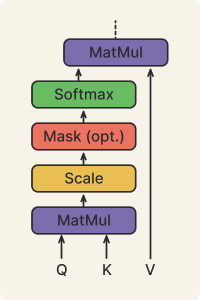

In [6]:
def scaled_dot_product_attn(Q, K, V, mask=None):
    d_k = K.size(-1)

    attn_weights = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)
    
    if mask is not None:
        attn_weights = attn_weights.masked_fill(mask, -1e13)

    attn_weights = F.softmax(attn_weights, dim=-1)
    
    attention_applied = torch.matmul(attn_weights, V)

    return attention_applied, attn_weights

### **Multihead attention**

Here is the multihead attention scheme from [original article](https://arxiv.org/pdf/1706.03762.pdf)

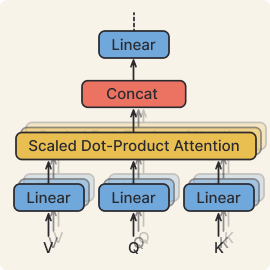

In [7]:
class Multihead_attention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(Multihead_attention, self).__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = self.d_model // self.n_heads

        assert (
            self.n_heads * self.d_head == self.d_model
        ), "d_head * n_heads must be equal to d_model!"

        self.W_Q = nn.Linear(self.d_model, self.d_model, bias=False)
        self.W_K = nn.Linear(self.d_model, self.d_model, bias=False)
        self.W_V = nn.Linear(self.d_model, self.d_model, bias=False)

        self.fc = nn.Linear(self.n_heads * self.d_head, self.d_model)

    def forward(self, Q, K, V, mask=None):
        batch_size = K.size(0)
        K_len = K.size(1)
        Q_len = Q.size(1)
        
        Q = self.W_Q(Q)
        K = self.W_K(K)
        V = self.W_V(V)

        Q = Q.reshape(batch_size, Q_len, self.n_heads, self.d_head)
        K = K.reshape(batch_size, K_len, self.n_heads, self.d_head)
        V = V.reshape(batch_size, K_len, self.n_heads, self.d_head)

        Q = Q.permute(0, 2, 1, 3)
        K = K.permute(0, 2, 1, 3)
        V = V.permute(0, 2, 1, 3)

        attention, attn_weights = scaled_dot_product_attn(Q, K, V, mask)
        attention = attention.permute(0, 2, 1, 3)
        attention = attention.reshape(batch_size, Q_len, self.d_model)

        attention = self.fc(attention)

        return attention, attn_weights

## **Encoder**

### **Encoder block**

Here is the block of encoder scheme from [original article](https://arxiv.org/pdf/1706.03762.pdf)

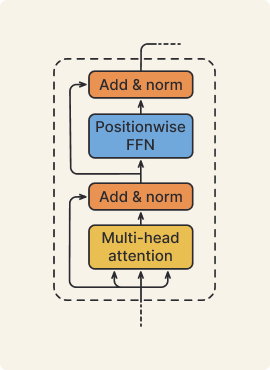

In [8]:
class Encoder_block(nn.Module):
    def __init__(self, d_model, n_heads, d_ffn, dropout_p=0.5):
        super(Encoder_block, self).__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_ffn = d_ffn
        self.dropout_p = dropout_p

        self.attention = Multihead_attention(self.d_model, self.n_heads)
        
        self.FFN = nn.Sequential(
            nn.Linear(self.d_model, self.d_ffn),
            nn.Dropout(self.dropout_p),
            nn.ReLU(),
            nn.Linear(self.d_ffn, self.d_model)
        )

        self.layer_norm_1 = nn.LayerNorm(self.d_model)
        self.layer_norm_2 = nn.LayerNorm(self.d_model)
        
        self.dropout = nn.Dropout(self.dropout_p)

    def forward(self, input, mask=None):
        attention_out, attention_weights = self.attention(input, input, input, mask)
        attention_out = input + self.dropout(attention_out)
        attention_out = self.layer_norm_1(attention_out)

        ffn_out = self.FFN(attention_out)
        ffn_out = attention_out + self.dropout(ffn_out)
        out = self.layer_norm_2(ffn_out)
        
        return out, attention_weights

### **Full encoder**

Here is the full encoder scheme from [original article](https://arxiv.org/pdf/1706.03762.pdf)

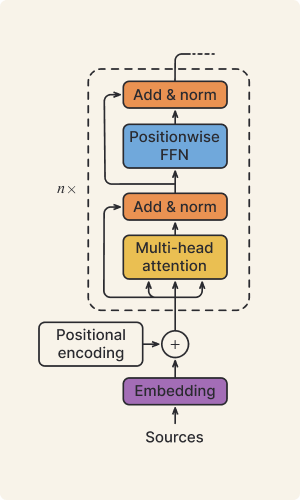

In [9]:
class Encoder(nn.Module):
    def __init__(self, model_params_dict, data_params_dict):
        super(Encoder, self).__init__()

        self.d_model = model_params_dict["d_model"]
        self.n_heads = model_params_dict["n_heads"]
        self.d_ffn = model_params_dict["d_ffn"]
        self.n_layers = model_params_dict["n_layers"]
        self.src_vocab_size = data_params_dict["src_vocab_size"]
        self.dropout_p = model_params_dict["dropout_p"]

        self.src_embedding = Embedding(self.src_vocab_size, self.d_model)
        self.positional_encoding = Positional_encoding(self.d_model)

        self.encoder_layers = nn.ModuleList([
            Encoder_block(self.d_model,
                          self.n_heads,
                          self.d_ffn,
                          self.dropout_p)
            for _ in range(self.n_layers)
        ])

    def forward(self, src, mask=None):
        encoder_input = self.src_embedding(src)
        encoder_input = self.positional_encoding(encoder_input)
        
        attention_weights = None

        for encoder_layer in self.encoder_layers:
            encoder_input, attention_weights = encoder_layer(
                encoder_input,
                mask
            )

        return encoder_input, attention_weights

## **Decoder**

### **Decoder block**

Here is the block of decoder scheme from [original article](https://arxiv.org/pdf/1706.03762.pdf)

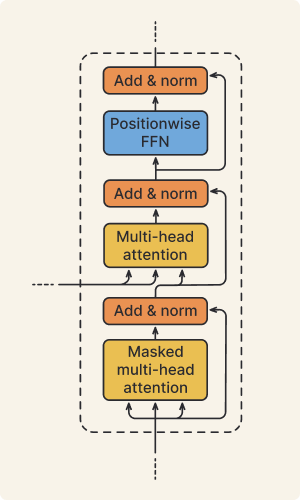

In [10]:
class Decoder_block(nn.Module):
    def __init__(self, d_model, n_heads, d_ffn, dropout_p):
        super(Decoder_block, self).__init__()
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_ffn = d_ffn
        self.dropout_p = dropout_p

        self.attention_1 = Multihead_attention(self.d_model, self.n_heads)
        self.attention_2 = Multihead_attention(self.d_model, self.n_heads)
        
        self.FFN = nn.Sequential(
            nn.Linear(self.d_model, self.d_ffn),
            nn.ReLU(),
            nn.Linear(self.d_ffn, self.d_model)
        )

        self.layer_norm_1 = nn.LayerNorm(self.d_model)
        self.layer_norm_2 = nn.LayerNorm(self.d_model)
        self.layer_norm_3 = nn.LayerNorm(self.d_model)
        
        self.dropout = nn.Dropout(self.dropout_p)

    def forward(self, encoder_outputs, decoder_inputs, target_mask, src_mask=None):
        attention_out_1, _ = self.attention_1(
            decoder_inputs,
            decoder_inputs,
            decoder_inputs,
            target_mask
        )
        attention_out_1 = self.dropout(attention_out_1) + decoder_inputs 
        attention_out_1 = self.layer_norm_1(attention_out_1)

        attention_out_2, attention_weights_2 = self.attention_2(
            attention_out_1,
            encoder_outputs,
            encoder_outputs,
            src_mask
        )
        attention_out_2 = self.dropout(attention_out_2) + attention_out_1 
        attention_out_2 = self.layer_norm_1(attention_out_2)

        ffn_out = self.FFN(attention_out_2)
        ffn_out = self.dropout(ffn_out) + attention_out_2
        out = self.layer_norm_3(ffn_out)
        
        return out, attention_weights_2

### **Full decoder**

Here is the full decoder scheme from [original article](https://arxiv.org/pdf/1706.03762.pdf)

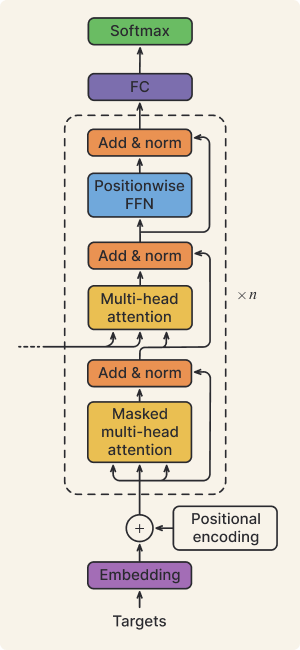

In [11]:
class Decoder(nn.Module):
    def __init__(self, model_params_dict, data_params_dict):
        super(Decoder, self).__init__()

        self.d_model = model_params_dict["d_model"]
        self.n_heads = model_params_dict["n_heads"]
        self.d_ffn = model_params_dict["d_ffn"]
        self.n_layers = model_params_dict["n_layers"]
        self.target_vocab_size = data_params_dict["target_vocab_size"]
        self.dropout_p = model_params_dict["dropout_p"]

        self.target_embedding = Embedding(self.target_vocab_size, self.d_model)
        self.positional_encoding = Positional_encoding(self.d_model)

        self.decoder_layers = nn.ModuleList([
            Decoder_block(self.d_model,
                          self.n_heads,
                          self.d_ffn,
                          self.dropout_p)
            for _ in range(self.n_layers)
        ])

        self.fc = nn.Linear(self.d_model, self.target_vocab_size)

    def forward(self, encoder_outputs, target, target_mask, src_mask):
        decoder_input = self.target_embedding(target)
        decoder_input = self.positional_encoding(decoder_input)
        attention_weights = None

        for decoder_layer in self.decoder_layers:
            decoder_input, attention_weights = decoder_layer(
                encoder_outputs,
                decoder_input,
                target_mask,
                src_mask
            )

        out = self.fc(decoder_input)

        return out, attention_weights

## **Transformer**

Now let's put the encoder and decoder together. We will get this scheme:

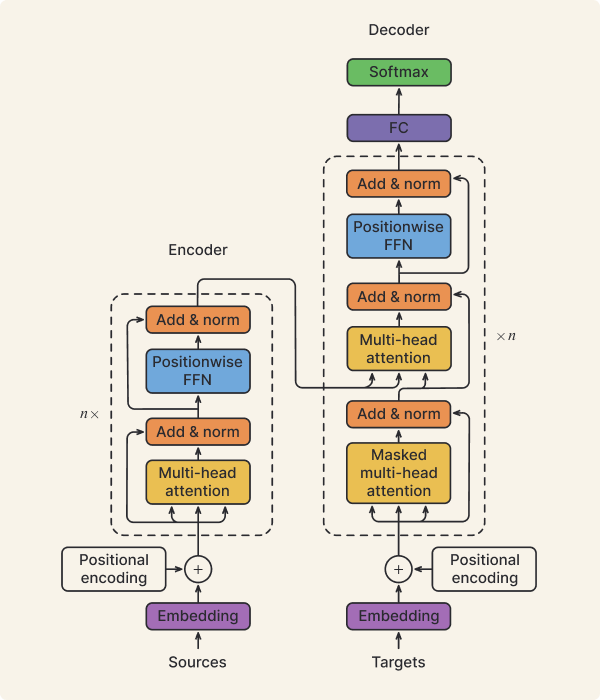

In [12]:
class Transformer(nn.Module):
    def __init__(self, model_params_dict, data_params_dict):
        super(Transformer, self).__init__()

        self.encoder = Encoder(model_params_dict, data_params_dict).to(device)
        self.decoder = Decoder(model_params_dict, data_params_dict).to(device)

    def forward(self, src_batch, target_batch):
        batch_size = target_batch.size(0)
        target_len = target_batch.size(1)

        src_padding_mask = (src_batch != 0)[:, None, None, :].to(device)
        target_padding_mask = (target_batch != 0)[:, None, None, :].to(device)

        look_ahead_mask = torch.tril(
            torch.ones((target_len, target_len))
        ).expand(batch_size, 1, target_len, target_len).to(device)
        
        target_mask = torch.minimum(
            target_padding_mask, look_ahead_mask
        ).to(device)

        encoder_out, _ = self.encoder(src_batch, src_padding_mask)

        decoder_out, attention_weights = self.decoder(encoder_out,
                                                      target_batch,
                                                      target_mask,
                                                      src_padding_mask)

        return decoder_out, attention_weights

In [13]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.xavier_uniform_(param.data.unsqueeze_(0))

# **Model**

In [14]:
model_params_dict = {
    "d_model": 512,
    "n_heads": 8,
    "n_layers": 6,
    "d_ffn": 2048,
    "dropout_p": 0.1
}

In [15]:
data_params_dict = {
    "src_vocab_size": 10,
    "target_vocab_size": 10
}

In [16]:
transformer = Transformer(model_params_dict,
                          data_params_dict).to(device)

transformer.apply(init_weights)

Transformer(
  (encoder): Encoder(
    (src_embedding): Embedding(
      (embedding): Embedding(10, 512)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (positional_encoding): Positional_encoding()
    (encoder_layers): ModuleList(
      (0-5): 6 x Encoder_block(
        (attention): Multihead_attention(
          (W_Q): Linear(in_features=512, out_features=512, bias=False)
          (W_K): Linear(in_features=512, out_features=512, bias=False)
          (W_V): Linear(in_features=512, out_features=512, bias=False)
          (fc): Linear(in_features=512, out_features=512, bias=True)
        )
        (FFN): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU()
          (3): Linear(in_features=2048, out_features=512, bias=True)
        )
        (layer_norm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer_norm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=T

In [17]:
total_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print("parameters count:", total_params)

parameters count: 44126218


# **Toy example**

In [18]:
def make_decoder_inputs_targets(target_batch):
    decoder_inputs = [sentence[:-1] for sentence in target_batch]
    decoder_targets = [sentence[1:] for sentence in target_batch]

    return decoder_inputs, decoder_targets

In [19]:
src_batch = [
    torch.Tensor([1, 3, 4, 5, 6, 7, 2]),
    torch.Tensor([1, 3, 4, 5, 7, 2])
]

target_batch = [
    torch.Tensor([1, 3, 4, 5, 9, 6, 7, 2]),
    torch.Tensor([1, 3, 4, 5, 2])
]

In [20]:
decoder_input, decoder_target = make_decoder_inputs_targets(target_batch)

src_batch = pad_sequence(
    src_batch, batch_first=True
).type("torch.LongTensor").to(device)
decoder_input = pad_sequence(
    decoder_input, batch_first=True
).type("torch.LongTensor").to(device)
decoder_target = pad_sequence(
    decoder_target, batch_first=True
).type("torch.LongTensor").to(device)

In [21]:
out, attn_weights = transformer(src_batch, decoder_input)
print(f"out size: {out.size()}")
print(f"out:\n{out}\n")
print(f"attn_weights size: {attn_weights.size()}")
print(f"attn_weights:\n{attn_weights}")

out size: torch.Size([2, 7, 10])
out:
tensor([[[-0.0038,  0.4486, -0.4517,  0.3078, -0.2433, -0.6049,  0.6106,
           0.4409, -0.6878, -0.7472],
         [-0.0091,  0.4403, -0.4499,  0.3200, -0.2299, -0.5959,  0.6084,
           0.4386, -0.6753, -0.7451],
         [-0.0154,  0.4476, -0.4459,  0.3112, -0.2317, -0.6035,  0.6089,
           0.4447, -0.6738, -0.7398],
         [-0.0195,  0.4444, -0.4598,  0.3093, -0.2298, -0.6069,  0.5983,
           0.4452, -0.6846, -0.7374],
         [-0.0080,  0.4459, -0.4456,  0.3164, -0.2365, -0.6076,  0.6132,
           0.4409, -0.6781, -0.7452],
         [-0.0073,  0.4462, -0.4583,  0.3243, -0.2301, -0.6107,  0.6029,
           0.4407, -0.6841, -0.7405],
         [-0.0062,  0.4549, -0.4452,  0.3204, -0.2380, -0.5979,  0.5991,
           0.4343, -0.6890, -0.7381]],

        [[-0.0183,  0.4576, -0.4430,  0.3170, -0.2403, -0.6013,  0.6040,
           0.4463, -0.6906, -0.7506],
         [-0.0067,  0.4523, -0.4448,  0.3177, -0.2392, -0.6063,  0.6067,